
<img src="https://raw.githubusercontent.com/archivesunleashed/archivesunleashed.org/master/themes/hugo-material-docs/static/images/logo-square.png" height="100px" width="100px">


# Welcome

Welcome to the Archives Unleashed Cloud Visualization Demo in Jupyter Notebook for your collection. This demonstration takes the main derivatives from the Cloud and uses Python to analyze and produce information about your collection.

This product is in beta, so if you encounter any issues, please post an [issue in our Github repository](https://github.com/archivesunleashed/auk/issues) to let us know about any bugs you encountered or features you would like to see included.

If you have some basic Python coding experience, you can change the code we provided to suit your own needs.

Unfortunately, we cannot support code that you produced yourself. We recommend that you use `File > Make a Copy` first before changing the code in the repository. That way, you can always return to the basic visualizations we have offered here. Of course, you can also just re-download the Jupyter Notebook file from your Archives Unleashed Cloud account.

### How Jupyter Notebooks Work:

If you have no previous experience of Jupyter Notebooks, the most important thing to understand is that that <Shift><Enter/Return> will run the python code inside a window and output it to the site.
    
The window titled `# RUN THIS FIRST` should be the first place you go. This will import all the libraries and set basic variables (e.g. where your derivative files are located) for the notebook. After that, everything else should be able to run on its own.

If you just want to see the results for your collection, use `Cell > Run All`.


In [393]:
# Required imports from sys

from collections import Counter
import logging

coll_id = "4656"
auk_fp = "./data/"
auk_full_text = auk_fp + coll_id + "-fulltext.txt"
auk_gephi = auk_fp + coll_id + "-gephi.gexf"
auk_graphml = auk_fp + coll_id + "-gephi.graphml"
auk_domains = auk_fp + coll_id + "-fullurls.txt"
auk_filtered_text = auk_fp + coll_id + "-filtered_text.zip"

In [394]:
def sanity_check():
    output = "This script will check if you have all required dependencies:\n\n"
    try:
        import matplotlib.pyplot
        output += "Matplotlib OK.\n"
    except ImportError:
        output += "ERROR MATPLOTLIB required: Matplotlib is required to show graph visualizations.\n"
        output += "                           Try `pip install -u matplotlib` to install.\n"
    try:
        import networkx
        output += "NetworkX OK.\n"
    except ImportError:
        output += "WARN NETWORKX: Networkx is required to show network graph visualizations.\n"
        output += "                           Try `pip install -u networkx` to install.\n"
    try:
        import ggplot
        output += "GGplot OK.\n"
    except ImportError:
        output += "WARN GGPlot: GGplot will improve graph visualizations.\n"
        output += "                           Try `pip install -u ggplot` to install.\n"
    try:
        import numpy
        output += "Numpy OK.\n"
    except ImportError:
        output += "WARN NUMPY MISSING: You will not be able to use some math features.\n"
        output += "                    Try `pip install -u numpy` to install.\n"
    try:
        import pandas
        output += "Pandas OK.\n"
    except ImportError:
        output += "WARN PANDAS MISSING: This means you cannot access dataframes.\n"
        output += "                     Try `pip install -u pandas` to install.\n"
    try: 
        import nltk
        from nltk.tokenize import word_tokenize, sent_tokenize
        from nltk.draw.dispersion import dispersion_plot as dp
        nltk.download('vader_lexicon')
        output += "Nltk OK.\n"
    except ImportError:
        output += "WARN NLTK MISSING: This means you cannot do text analysis.\n"
        output += "                   Try `pip install -u nltk` to install.\n"
    try:
        open(auk_full_text)
        output += "Full text OK.\n"
    except NameError:
        output += "ERROR No File Variables: Looks like you forgot to run the first window.\n"
        output += "                         Use <SHIFT><RETURN/ENTER> on the first code window\n"
    except FileNotFoundError:
        output += "ERROR No File Access: Could not open the full-text file.\n"
        output += "                      Did you remember to include the downloads in the same folder?\n"
    try:
        open(auk_gephi)
        output += "Gephi OK.\n"
    except NameError:
        output += "ERROR No File Variables: Looks like you forgot to run the first window.\n"
        output += "                         Use <SHIFT><RETURN/ENTER> on the first code window\n"
    except FileNotFoundError:
        output += "ERROR No File Access: Could not open the gephi file.\n"
        output += "                      Did you remember to include the downloads in the same folder?\n"
    try:
        open(auk_domains)
        output += "Domains OK.\n"
    except NameError:
        output += "ERROR No File Variables: Looks like you forgot to run the first window.\n"
        output += "                         Use <SHIFT><RETURN/ENTER> on the first code window\n"
    except FileNotFoundError:
        output += "ERROR No File Access: Could not open the domains file.\n"
        output += "                      Did you remember to include the downloads in the same folder?\n"
    return (output)

print(sanity_check())
    
    

This script will check if you have all required dependencies:

Matplotlib OK.
NetworkX OK.
GGplot OK.
Numpy OK.
Pandas OK.
Nltk OK.
Full text OK.
Gephi OK.
Domains OK.



[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/ryandeschamps/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


# Text Analysis

The following set of functions use the [Natural Language Toolkit](https://www.nltk.org) Python library to search for the top most used words in the collection, as well as facilitate breaking it down by name or domain.

Set the variables below if you wish to make some changes.

In [395]:
##  CONSTANTS / CONFIGURATION
#
# If you wish to fine tune the outputs, you may change the following:
#
# maximum number of words to show in output.
# Jupyter will create an output error if the number is too high.
TOP_COUNT = 30 

# Domain suffixes to check non-U.S. domains.
# so that (e.g.) www.google.co.uk will become "google"
STOP_DOMAINS = ["co", "org", "net", "edu"] # domain suffixes to remove

# minimum number of characters for a word to be included in a corpus
MINIMUM_WORD_LENGTH = 3 # eliminates "it", "I", "be" etc.

# list of substrings to filter a text line, if desired
LINE_FILTER = ['404 Not Found']

# The number of the last line of text to ingest
RESULTS_LIMIT = 2500

# If you want to start ingesting at a different line, you can increase this.
# If RESULTS_START is great than RESULTS_LIMIT you will get no results.
RESULTS_START = 0

# If you have a large file but want to sample the file more broadly, you
# can increase this value skip to every Nth line.
RESULTS_STEP = 5

# change if you want a different filename.
OUTPUT_FILENAME = "./filtered_text.txt" # filename if you want to output to another file.

# characters to show per text file in output. Larger numbers will results in more
# text showing in output
MAX_CHARACTERS = 75

# The years to include in the analysis. If empty, you will get all available years.
FILTERED_YEARS = [] # e.g. ['2015', '2016', '2019']

# The domains to include in the analysis. If empty, you will get all available domains.
FILTERED_DOMAINS = [] # e.g ["google", "apple", "facebook"]

# List of words not to include in a corpus for text analysis
STOP_WORDS = ['this', 'that', 'with', 'from', 'your']

## Toolkit imports
import matplotlib.pyplot as pp
import pandas as pd
import numpy as np
import networkx as nx
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.draw.dispersion import dispersion_plot as dp
from nltk.classify import NaiveBayesClassifier
from nltk.corpus import subjectivity
from nltk.sentiment import SentimentAnalyzer
from nltk.sentiment.util import *
from nltk.sentiment.vader import SentimentIntensityAnalyzer

def clean_domain(s):
    """Extracts the name from the domain (e.g. 'www.google.com' becomes 'google')."""
    ret = ""
    dom = s.split(".")
    if len(dom) <3: # x.com is always x
        ret = dom[0]
    elif dom[-2] in STOP_DOMAINS: # www.x.co.uk should be x
        ret = dom[-3]
    else:
        ret = dom[1]
    return ret


def get_text(by="all", minline=MINIMUM_WORD_LENGTH):
    """Get just the text from the files."""
    text = []
    form = range(RESULTS_START, RESULTS_LIMIT, RESULTS_STEP)
    with open(auk_full_text) as fin:
        for num in range(RESULTS_LIMIT):
            if num in form:
                line = next(fin)
                split_line = str(line).split(",", 3)
                if (len(split_line[3]) >= MINIMUM_WORD_LENGTH and set([split_line[3].find(x) for x in LINE_FILTER]) == {-1}):   
                    if by == "domain": 
                        text.append((clean_domain(split_line[1]), split_line[3]))
                    elif by == "year":
                        text.append((split_line[0][1:5], split_line[3]))
                    else:
                        text.append(split_line[3])
            else:
                next(fin)                   
    return text

def get_text_tokens (minlen=MINIMUM_WORD_LENGTH) :
    """Get the data and tokenize the text."""
    tokens = []
    with open (auk_full_text) as fin:
        head = [next(fin) for x in range(RESULTS_LIMIT)]
    for line in head:
        split_line = str(line).lower().split(",", 3)
        # remove lines that are smaller than 3 chars or in the FILTER list.
        if (len(split_line[3]) >= minlen and set([split_line[3].find(x) for x in LINE_FILTER]) == {-1}):
            tokens += word_tokenize(split_line[3])
    tokens = [x for x in tokens if len(x) > minlen]
    return tokens

def get_tokens_domains(minlen=MINIMUM_WORD_LENGTH):
    """Get tokens by domain"""
    tokens = []
    with open (auk_full_text) as fin:
        head = [next(fin) for x in range(RESULTS_LIMIT)]
    for line in head:
        split_line = str(line).lower().split(",", 3)
        if (len(split_line[3]) >= minlen and set([split_line[3].find(x) for x in LINE_FILTER]) == {-1}):
            tokens.append((clean_domain(split_line[1]), Counter([x for x in word_tokenize(str(split_line[3])) if len(x) > minlen])))
    return tokens

def get_tokens_years(minlen=MINIMUM_WORD_LENGTH):
    """Get tokens by year."""
    tokens = []
    with open (auk_full_text) as fin:
        head = [next(fin) for x in range(RESULTS_LIMIT)]
    for line in head:
        split_line = str(line).lower().split(",", 3)
        if (len(split_line[3]) >= minlen and set([split_line[3].find(x) for x in LINE_FILTER]) == {-1}):
            tokens.append((split_line[0][1:5], Counter([x for x in word_tokenize(str(split_line[3])) if len(x) > minlen])))
    return tokens

def year(minlen=MINIMUM_WORD_LENGTH):
    """Used by get_top_tokens_by to get the tokens by year."""
    return get_tokens_years(minlen)

def domain(minlen=MINIMUM_WORD_LENGTH):
    """Used by get_top_tokens_by to get tokens by domain."""
    return get_tokens_domains(minlen)
 
def get_top_tokens(total=TOP_COUNT, minlen=MINIMUM_WORD_LENGTH):
    """Return the top tokens for the text."""
    return [(key, value) for key, value in Counter(get_text_tokens(minlen)).most_common(total)]

def get_top_tokens_by(fun, total=TOP_COUNT, minlen=MINIMUM_WORD_LENGTH):
    """ Get the top tokens by a function.
    
    Parameters
    ----------
    fun: A function that returns a list of (key, Counter([tokenized_list]))
    total: The number of top tokens to return for each key.
    minlen: The minimum word length.
    
    Returns
    -------
    ret: list of minlen tokens by fun.
    """
    
    sep = dict()
    tokens = fun(minlen)
    sep = {k[0]: Counter() for k in tokens}
    for key, value in tokens:
        sep[key] += value
    ret = [(key, val.most_common(total)) for key, val in sep.items()]
    return (ret)

# applies utf-16 encoding to text, if possible
def international(text):
    unicode = text.encode("utf-8")
    try:
        ret = unicode.decode("UTF-32-LE")
    except UnicodeDecodeError:
        try:
            ret = unicode.decode("UTF-32-BE")
        except UnicodeDecodeError:
            try: 
                ret = unicode.decode("UTF-16-LE")
            except UnicodeDecodeError:
                try: 
                    ret = unicode.decode("UTF-16-BE")
                except UnicodeDecodeError:
                    logging.warning("Could not convert text to UTF-16 or UTF-32. Restoring UTF-8")
                    ret = unicode.decode("UTF-8")
            
    return ret

# writes results to stdout
def write_output (stdout, results):
    try:
        with open(filename, "w") as output:
            for value in results:
                output_file_write(str(value))
    except:
        print("Error writing the file.")
        
def sentiment_scores(by="domain"):
    sep = dict()
    corpus = get_text(by)
    sep = {k[0]: [] for k in corpus}
    for key, value in corpus:
        sep[key] += sent_tokenize(value)
    sid = SentimentIntensityAnalyzer()
    result = []
    for a, b in sep.items():
        scores = Counter({"neg": 0, "pos":0, "neu":0, "compound":0})
        for c in b:
            scores.update(sid.polarity_scores(c))
        result += [(a, ("neg", scores['neg']/len(b)), ("pos", scores['neg']/len(b)), ("neu", scores['neu']/len(b)), ("compound", scores['compound']/len(b)))]
      #  [(key, sid.polarity_scores(text)) for key, text in sep.items()]
    return(result)

Now that you have saved the above functions, you can now use them in a variety of ways. 

### Text by Year

In [396]:
method = "year" # choose "year", "domain" or "all"

# Get the set of available years in the collection 
year_range = set([x[0] for x in get_text(method)])
print(year_range)

{'2009', '2016'}


Now we can create separate lists with text files from individual years in this collection. You can add years (e.g. "2019") to `filtered_range` to limit your results.

In [397]:
year_filter = FILTERED_YEARS if FILTERED_YEARS else year_range # add or remove years for filter
year_results = [t[1] for t in get_text("year") if t[0] in list(year_filter)]
    
# Some of the text may be in an international font.
for i in year_results[:5]:
    print(international(i)[:MAX_CHARACTERS]) # first 50 characters in output

## Commenting out the following will write the results to a `output_filename

#write_output(output_filename, year_results)

慎慮浩⁯慄汩⁹敎獷ⴠ䰠捯污丠睥ⱳ匠潰瑲ⱳ䔠瑮牥慴湩敭瑮††††††††††††吠杯汧⁥慮楶慧楴湯䠠浯⁥畏⁲敔浡䌠湯慴瑣唠⁳摁敶瑲獩湩⁧湉潦丠睥⁳䍂丠睥
〳′潆湵⁤潆湵⁤桔⁥潤畣敭瑮栠獡洠癯摥栠牥⹥਩
Place - schema.org schema.org Documentation Schemas Home Place Thing > Plac
慎慮浩⁯慄汩⁹敎獷ⴠ攠摅瑩潩獮删慥⁬獅慴整攠䔭楤楴湯传楢獴㈠숷₰畓湮⁹潈敭传牵吠慥⁭潃瑮捡⁴獕䄠癤牥楴楳杮䤠普⁯敎獷䈠⁃敎獷匠潰瑲⁳䍂匠潰瑲⁳䍂䜠浡獥
捁畣敗瑡敨⹲潣⁭敗瑡敨⁲慃慮楤湡䌠瑩敩㩳䤠瑮牥慮楴湯污䰠捯瑡潩獮술₠慖据畯敶Ⱳ䈠⁃畃牲湥⁴潃摮瑩潩獮㈠숴䎰删慥䙬敥쉬㪮㈠숷䎰䠠浵摩瑩㩹㔠┲䌠潬摵䌠癯牥


### Text by Domain

In [398]:
# Get the set of available domains in the collection 
domain_set = set([x[0] for x in get_text("domain")])
print(domain_set)

{'accuweather', 'nanaimodailynews', 'schema', 'save', 'issuu'}


In [399]:
# extract only the given domain to a file and see how many results there are

domain_set = FILTERED_DOMAINS if FILTERED_DOMAINS else domain_set
domain_results = [t[1] for t in get_text("domain") if t[0] in domain_set]
print("****Total files****:" + str(len(domain_results)) + "\n")
print("****Sample results****: \n")
for samp in domain_results[:10]:
    if len(samp) > 4:
        print(international(samp)[:MAX_CHARACTERS] + " \n")

****Total files****:498

****Sample results****: 

慎慮浩⁯慄汩⁹敎獷ⴠ䰠捯污丠睥ⱳ匠潰瑲ⱳ䔠瑮牥慴湩敭瑮††††††††††††吠杯汧⁥慮楶慧楴湯䠠浯⁥畏⁲敔浡䌠湯慴瑣唠⁳摁敶瑲獩湩⁧湉潦丠睥⁳䍂丠睥 

〳′潆湵⁤潆湵⁤桔⁥潤畣敭瑮栠獡洠癯摥栠牥⹥਩ 

Place - schema.org schema.org Documentation Schemas Home Place Thing > Plac 

慎慮浩⁯慄汩⁹敎獷ⴠ攠摅瑩潩獮删慥⁬獅慴整攠䔭楤楴湯传楢獴㈠숷₰畓湮⁹潈敭传牵吠慥⁭潃瑮捡⁴獕䄠癤牥楴楳杮䤠普⁯敎獷䈠⁃敎獷匠潰瑲⁳䍂匠潰瑲⁳䍂䜠浡獥 

捁畣敗瑡敨⹲潣⁭敗瑡敨⁲慃慮楤湡䌠瑩敩㩳䤠瑮牥慮楴湯污䰠捯瑡潩獮술₠慖据畯敶Ⱳ䈠⁃畃牲湥⁴潃摮瑩潩獮㈠숴䎰删慥䙬敥쉬㪮㈠숷䎰䠠浵摩瑩㩹㔠┲䌠潬摵䌠癯牥 

Advertise                        Toggle navigation Home Our Team Contact Us 

慎慮浩⁯慄汩⁹敎獷ⴠ䈠獵湩獥⁳敒污䔠瑳瑡⁥ⵥ摅瑩潩⁮扏瑩⁳㜲냂匠湵祮䠠浯⁥畏⁲敔浡䌠湯慴瑣唠⁳摁敶瑲獩湩⁧湉潦丠睥⁳䍂丠睥⁳灓牯獴䈠⁃灓牯獴䈠⁃慇敭⁳ 

Our Town                        Toggle navigation Home Our Team Contact Us  

Nanaimo Daily News - Poll Real Estate e-Edition Obits 27° Sunny Home Our Te 

灓牯獴丠睥⁳†††††††††††吠杯汧⁥慮楶慧楴湯䠠浯⁥畏⁲敔浡䌠湯慴瑣唠⁳摁敶瑲獩湩⁧湉潦丠睥⁳䍂丠睥⁳灓牯獴䈠⁃灓牯獴䈠⁃慇敭⁳䙎⁌畂楳敮獳䈠⁃ 



## Overall Collection Characteristics

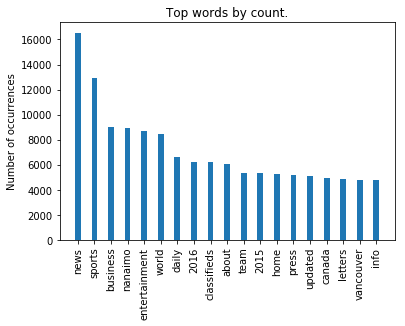

In [400]:


# Get a list of the top words in the collection
# (regardless of year).
tokens = get_top_tokens()[:20]

# Collect sentiment scores by domain and visualize them.

vals = [x[1] for x in tokens if x[0] not in STOP_WORDS]
labs = [x[0] for x in tokens if x[0] not in STOP_WORDS]

ind = np.arange(len(vals))    # the x locations for the groups
width = 0.35       # the width of the bars: can also be len(x) sequence

p1 = pp.bar(ind, vals, width)

pp.ylabel('Number of occurrences')
pp.title('Top words by count.')
pp.xticks(ind, labs, rotation='vertical')

pp.show()

In [401]:
# Get a list of the top tokens, separated by year.
get_top_tokens_by(year)[0:10]

[('2016',
  [('news', 16480),
   ('sports', 12938),
   ('business', 9028),
   ('nanaimo', 8907),
   ('entertainment', 8678),
   ('world', 8481),
   ('with', 8450),
   ('daily', 6646),
   ('2016', 6215),
   ('classifieds', 6211),
   ('about', 6067),
   ('team', 5367),
   ('2015', 5292),
   ('home', 5284),
   ('press', 5175),
   ('updated', 5053),
   ('canada', 4958),
   ('letters', 4899),
   ('vancouver', 4800),
   ('info', 4769),
   ('jobs', 4747),
   ('contact', 4742),
   ('advertising', 4699),
   ('opinion', 4686),
   ('careers', 4677),
   ('what', 4656),
   ('that', 4593),
   ('games', 4537),
   ('black', 4369),
   ('town', 4095)]),
 ('2009',
  [('news', 47),
   ('2016', 24),
   ('sports', 19),
   ('posted', 18),
   ('updated', 18),
   ('nanaimo', 17),
   ('entertainment', 16),
   ('2015', 16),
   ('community', 15),
   ('10:00', 13),
   ('business', 12),
   ('with', 11),
   ('daily', 9),
   ('11:28', 9),
   ('found', 8),
   ('world', 7),
   ('home', 6),
   ('calendar', 6),
   ('town

In [ ]:
# Get a list of top tokens, separated by domain.
get_top_tokens_by(domain)[0:10]

In [ ]:
# Create a dispersion plot, showing where the list of words appear
# in the text.
text = get_text_tokens(1) # Need to have one to include words with fewer than 3 letters.
dp(text, ["he", "she"]) # uses the nltk dispersion plot library (dp).

In [ ]:
# Collect sentiment scores by domain and visualize them.

sent = sentiment_scores()
N = len(sent)
neg = [x[1][1] for x in sent]
pos = [x[2][1] for x in sent]
neu = [x[3][1] for x in sent]
labs = [x[0] for x in sent]

ind = np.arange(N)    # the x locations for the groups
width = 0.35       # the width of the bars: can also be len(x) sequence

p1 = pp.bar(ind, neg, width)
p2 = pp.bar(ind, neu, width,
             bottom=neg)
p3 = pp.bar(ind, pos, width, bottom=neu)

pp.ylabel('Scores')
pp.title('Scores by domain and sentiment')
pp.xticks(ind, labs, rotation='vertical')
pp.legend((p1[0], p2[0], p3[0]), ('Negative', 'Neutral', 'Positive'))

pp.show()


In [ ]:
# Collect sentiment scores by year and visualize them.

sent = sentiment_scores("year")
N = len(sent)
neg = [x[1][1] for x in sent]
pos = [x[2][1] for x in sent]
neu = [x[3][1] for x in sent]
labs = sorted([x[0] for x in sent])

ind = np.arange(N)    # the x locations for the groups
width = 0.35       # the width of the bars: can also be len(x) sequence

p1 = pp.bar(ind, neg, width)
p2 = pp.bar(ind, neu, width,
             bottom=neg)
p3 = pp.bar(ind, pos, width, bottom=neu)

pp.ylabel('Scores')
pp.title('Scores by domain and sentiment')
pp.xticks(ind, labs, rotation='vertical')
pp.legend((p1[0], p2[0], p3[0]), ('Negative', 'Neutral', 'Positive'))

pp.show()

# Network Analysis

Sometimes it is useful to include information about the relationships among different websites. The field of social network analysis is varied, but we have a few examples here.

# Bibliography

Bird, Steven, Edward Loper and Ewan Klein (2009), *Natural Language       Processing with Python*. O’Reilly Media Inc.

Archives Unleashed Project. (2018). Archives Unleashed Toolkit (Version 0.17.0). Apache License, Version 2.0.